In [2]:
import string
import numbers
import math
import numpy as np
import pandas as pd
import cv2 as cv
import pprint
import scipy
import scipy.special
import scipy.spatial
import scipy.stats
import scipy.stats.qmc
import scipy.ndimage
import shapely
import shapely.geometry
import matplotlib
import matplotlib.patches
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.collections as mc
from matplotlib.path import Path
from tabulate import tabulate
import networkx as nx

import utility as util
pp = pprint.PrettyPrinter(indent=4)

(-1.0, 2.0)

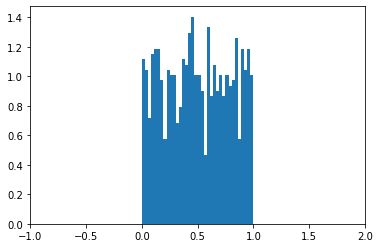

In [21]:
# uniform
x = np.random.uniform(0, 1, size=1000)
ax = plt.gca()
ax.hist(x, bins=36, density=True)
ax.set_xlim([-1, 2])

(-5.0, 5.0)

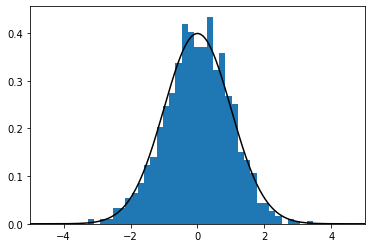

In [20]:
# normal
x = np.random.normal(loc=0.0, scale=1.0, size=1000)
ax = plt.gca()
ax.hist(x, bins=36, density=True)

x = np.linspace(-5, 5, 1000)
y = (1 / np.sqrt(2*np.pi))*np.exp(-x**2/2)
ax.plot(x, y, c="k")

ax.set_xlim([-5, 5])

(0.0, 1.0)

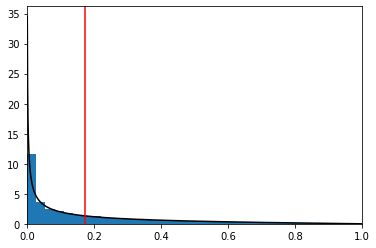

In [78]:
# beta distribution
# Based on
# https://www.desmos.com/calculator/pct1rbpkgv
# gamma function is G(z) = integrate{0, infty} t^{z-1} e^{-t} dt
# beta PDF is f(x;a,b) = G(a+b)/[G(a)G(b)] x^{a - 1}(1-x)^{b-1}

a = 0.4; b = 1.9
x = np.random.beta(a, b, size=10000)
ax = plt.gca()
ax.hist(x, bins=36, density=True)

x = np.linspace(0.001, 0.999, 1000)
y = x**(a - 1) * (1 - x)**(b - 1) / scipy.special.beta(a, b)
ax.plot(x, y, c="k")

plt.axvline(x=1/(1 + b/a), color="r", label="mean")

ax.set_xlim([0, 1])

(0.0, 50.0)

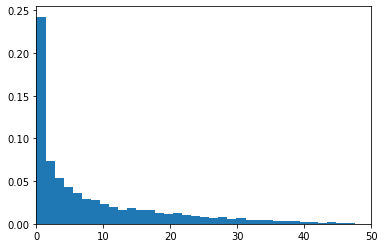

In [84]:
def map_01_to_uv(u, v):
    return lambda x: x*(v - u) + u

def map_uv_to_01(u, v):
    return lambda x: (x - u)/(v - u)

a = 0.4; b = 2.0
x = np.random.beta(a, b, size=10000)
u = 0; v = 50
x = map_01_to_uv(u, v)(x)
ax = plt.gca()
ax.hist(x, bins=36, density=True)
ax.set_xlim([u, v])

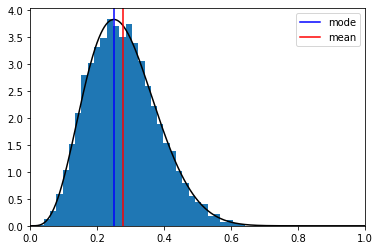

In [74]:
# beta with a mode
a = 5; b = 13
x = np.random.beta(a, b, size=10000)
ax = plt.gca()
ax.hist(x, bins=36, density=True)

x = np.linspace(0.001, 0.999, 1000)
y = x**(a - 1) * (1 - x)**(b - 1) / scipy.special.beta(a, b)
ax.plot(x, y, c="k")

plt.axvline(x=(a - 1)/(a + b - 2), color="b", label="mode")
plt.axvline(x=1/(1 + b/a), color="r", label="mean")

ax.set_xlim([0, 1])
ax.legend()

(-20.0, 90.0)

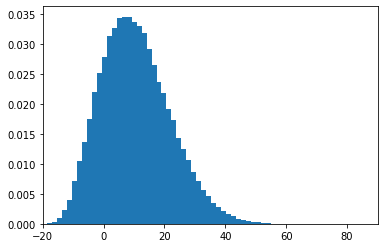

In [75]:
def map_01_to_uv(u, v):
    return lambda x: x*(v - u) + u

def map_uv_to_01(u, v):
    return lambda x: (x - u)/(v - u)

a = 5; b = 13
x = np.random.beta(a, b, size=100000)
u = -20; v = 90
x = map_01_to_uv(u, v)(x)
ax = plt.gca()
ax.hist(x, bins=50, density=True)
ax.set_xlim([u, v])



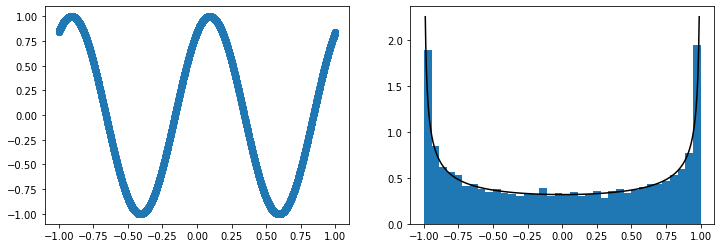

In [19]:
# Implicit Neural Representations with Periodic Activation Functions, SIREN
# https://arxiv.org/abs/2006.09661
# for a > \pi / 2 then and any b, if x ~ Unif[-1,1] and y = sin(ax+b) then y ~ Arcsine[-1,1]
N = 10000
x = np.random.uniform(low=-1, high=1, size=N)
a = 4 * np.pi / 2
b = 1
plt.figure(figsize=(12,4))
y = np.sin(a*x + b)

ax = plt.subplot(121)
ax.scatter(x, y)
ax = plt.subplot(122)
ax.hist(y, bins=36, density=True)

# Arcsine distribution
# https://en.wikipedia.org/wiki/Arcsine_distribution
x = np.linspace(-0.99, 0.99, 1000)
y = 1 /(np.pi * np.sqrt((x + 1)*(1 - x)))
ax.plot(x, y, c="k")

None